In [1]:
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
from lmfit.models import GaussianModel

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Peak estimation

In [2]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))      

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data
#PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"


In [136]:
#per il sodio
ch_1=[0,1,4,11,12, 6]
ch_2=[2,15]
ch_3=[3,5,7,13,14]
ch_4=[9,10]

In [ ]:
#per il bario
ch_1=[0, ]

In [99]:
channel=4

In [100]:
PATH="../Dati/Run_Ba_50_1000_ChargeHistos_5_16_2024.dat"
#PATH="../Dati/Run_Ba_40_600_ChargeHistos_5_16_2024.dat"
#if channel==8:
    #PATH="../Dati/Run_ch8_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH)#, usecols=(0,1,2,3,4,5,6))
#edge_N, bin_N = np.loadtxt(PATH, usecols=(0,1,2,3,4,5,6))


channel_idx = np.arange(0,16, step=1)

# Na peak

## Peak e+e-

In [109]:
edge_N, bin_N = load_histo(PATH_SAM)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [111]:
lim_list = [[-575, -460],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1850, -1550],  #ch2
            [-1200, -1000],  #ch3
            [-825, -700],  #ch4
            [-1400, -1160],  #ch5
            [-920, -775],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

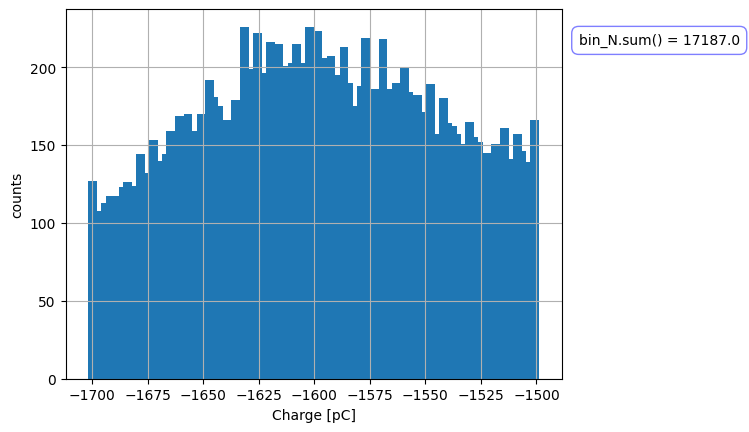

In [112]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

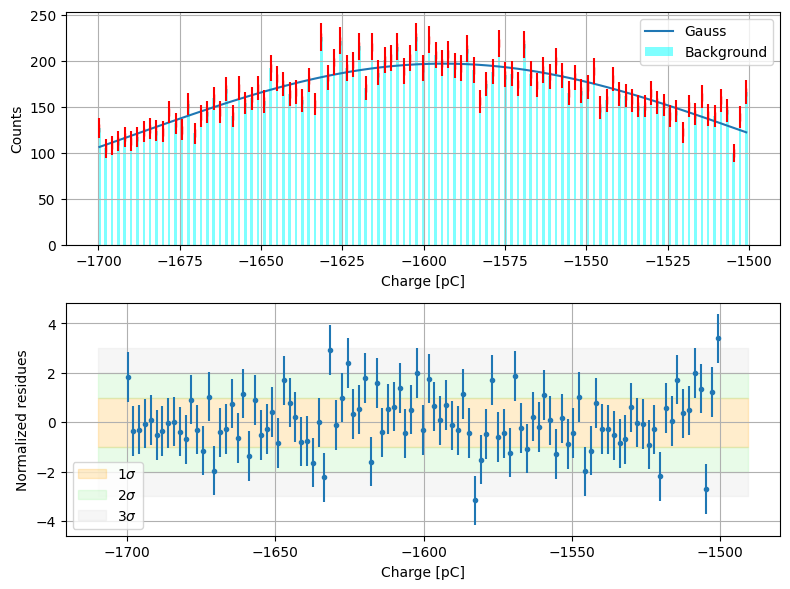

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 103
    # variables        = 3
    chi-square         = 138.144461
    reduced chi-square = 1.38144461
    Akaike info crit   = 36.2378100
    Bayesian info crit = 44.1419970
    R-squared          = 0.75493485
[[Variables]]
    g3_amplitude:  47028.5494 +/- 1033.00920 (2.20%) (init = 30221.1)
    g3_center:    -1593.87293 +/- 1.55832505 (0.10%) (init = -1594.435)
    g3_sigma:      95.3054020 +/- 2.78449663 (2.92%) (init = 79.95)
    g3_fwhm:       224.427067 +/- 6.55698835 (2.92%) == '2.3548200*g3_sigma'
    g3_height:     196.858491 +/- 2.53694149 (1.29%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9116
    C(g3_amplitude, g3_center) = +0.2307
    C(g3_center, g3_sigma)     = +0.2175


In [113]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## f peak

In [244]:
channel=15

In [245]:
if channel in ch_1:
    PATH_SAM="../Dati/Run_1M_50_3000_ChargeHistos_5_10_2024.dat"
elif channel in ch_2:
    PATH_SAM="../Dati/Run_2M_50_5000_ChargeHistos_5_10_2024.dat"
elif channel in ch_3:
    PATH_SAM="../Dati/Run_2M_50_4000_ChargeHistos_5_10_2024.dat"
elif channel in ch_4:
    PATH_SAM="../Dati/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"
if channel==8:
    PATH_SAM="../Dati/Run_ch8_ChargeHistos_5_10_2024.dat"


#PATH_SAM="../Dati/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)



channel_idx = np.arange(0,16, step=1)

In [246]:
edge_N, bin_N = load_histo(PATH_SAM)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [256]:
lim_list = [[-1345, -1127],  #ch0
            [-1250, -1040],      #ch1
            [-4400, -3750],  #ch2
            [-2950, -2550],  #ch3
            [-2000, -1700],  #ch4
            [-3390, -2800],  #ch5
            [-2300, -1900],  #ch6
            [-3200, -2700],  #ch7
            [-2450, -2155],  #ch8
            [-1350, -1100],  #ch9
            [-1150, -1000],  #ch10
            [-2100, -1750],  #ch11
            [-1900, -1600],      #ch12
            [-3000, -2500],      #ch13
            [-3000, -3500],  #ch14
            [-4200, -3500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

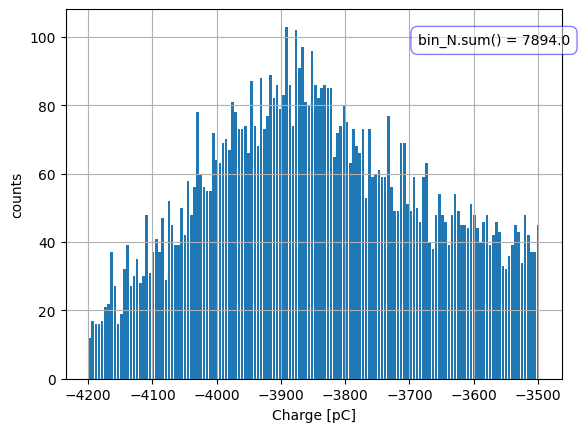

In [257]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

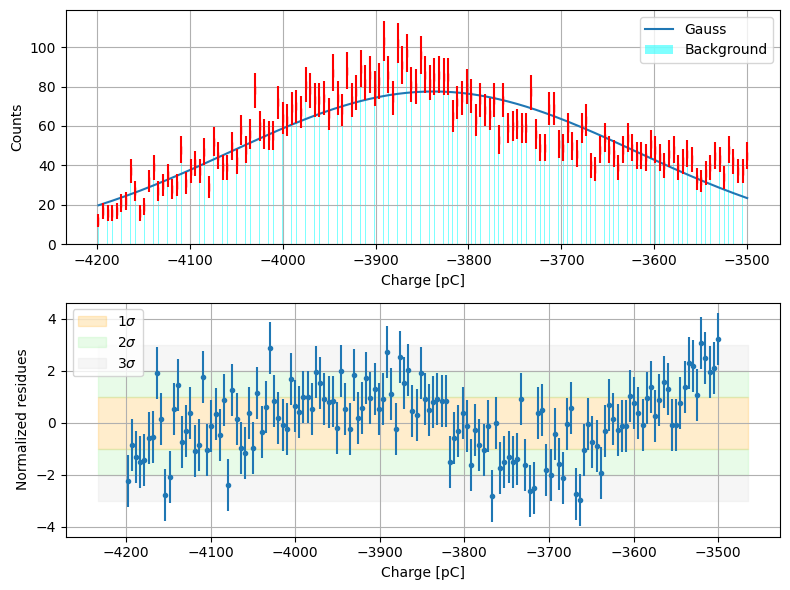

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 142
    # variables        = 3
    chi-square         = 258.582067
    reduced chi-square = 1.86030264
    Akaike info crit   = 91.1128206
    Bayesian info crit = 99.9803018
    R-squared          = 0.76683852
[[Variables]]
    g3_amplitude:  42348.5545 +/- 776.936964 (1.83%) (init = 50675.62)
    g3_center:    -3837.62880 +/- 4.46804932 (0.12%) (init = -3864.407)
    g3_sigma:      218.068390 +/- 5.29597928 (2.43%) (init = 185.625)
    g3_fwhm:       513.511806 +/- 12.4710779 (2.43%) == '2.3548200*g3_sigma'
    g3_height:     77.4739967 +/- 1.65901533 (2.14%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.5250
    C(g3_center, g3_sigma)     = +0.2080
    C(g3_amplitude, g3_center) = +0.1314


In [258]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## conclusions

In [88]:
peak_e=np.abs(np.array([-506.734, -461.730, -1673.738, -1085.422, -758.996, -1258.207, -854.866, -1216.707, -948.590, -506.800,
       -437.591, -776.004, -705.231, -1121.940, -1111.193, -1593.873]))
sigma_e=np.array([0.715, 0.789, 0.664, 0.844, 0.620, 1.360, 0.91, 1.116, 0.613, 1.236, 
         0.469, 0.955, 1.196, 0.961, 1.043, 1.558])
peak_f=np.abs(np.array([-1216.816, -1142.936, -4043.482, -2679.389, -1825.805, -3077.995, -2076.421, -2938.099, -2288.095, -1217.833,
       -1056.445, -1899.582, -1726.943, -2728.146, -2700.407, -3837.629] ))
sigma_f=np.array([1.615, 1.780, 2.493, 3.325, 1.683, 3.790, 2.369, 3.218, 1.281, 1.511,
        0.967, 2.157, 2.608, 2.609, 2.604, 4.468])

# Ba peaks

## peak 1

In [101]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [110]:
lim_list = [[-575, -460],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1850, -1550],  #ch2
            [-108, -55],  #ch3
            [-70, -50],  #ch4
            [-1400, -1160],  #ch5
            [-920, -775],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

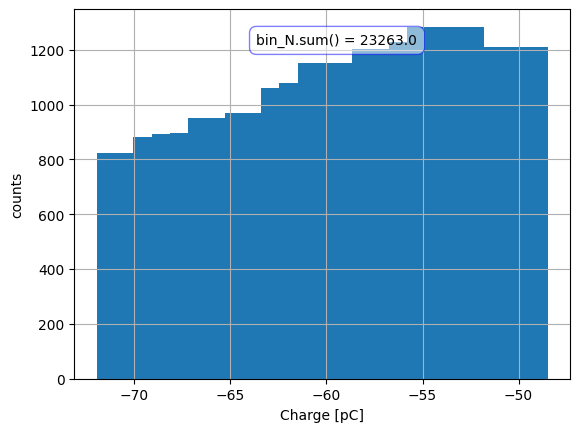

In [111]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")


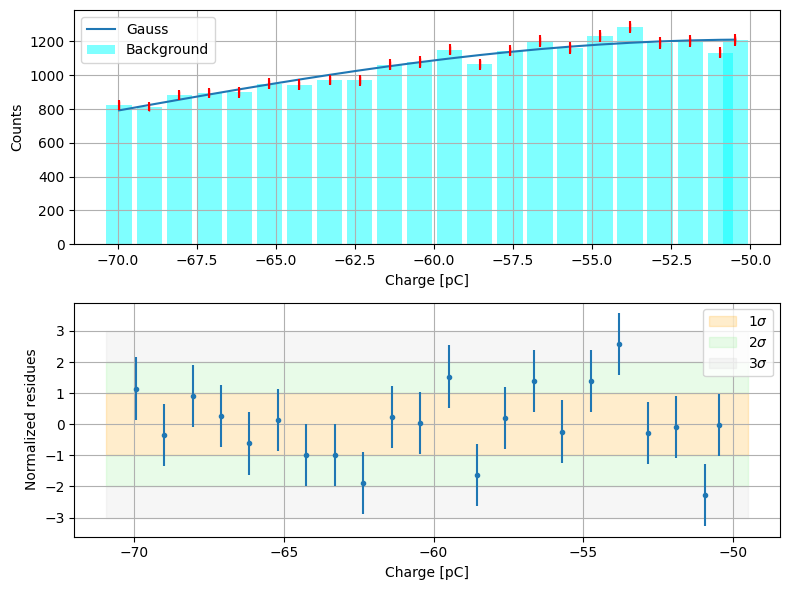

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 22
    # variables        = 3
    chi-square         = 29.1356765
    reduced chi-square = 1.53345666
    Akaike info crit   = 12.1802613
    Bayesian info crit = 15.4533886
    R-squared          = 0.92496385
[[Variables]]
    g3_amplitude:  65916.1802 +/- 9222.37732 (13.99%) (init = 7702.125)
    g3_center:    -49.9404502 +/- 2.49292909 (4.99%) (init = -55.73654)
    g3_sigma:      21.7185058 +/- 2.67653978 (12.32%) (init = 5.4625)
    g3_fwhm:       51.1431719 +/- 6.30276943 (12.32%) == '2.3548200*g3_sigma'
    g3_height:     1210.79934 +/- 26.6121716 (2.20%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9941
    C(g3_amplitude, g3_center) = +0.9835
    C(g3_center, g3_sigma)     = +0.9651


In [112]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## peak 2

In [113]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [117]:
lim_list = [[-575, -460],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1850, -1550],  #ch2
            [-220, -140],  #ch3
            [-160, -100],  #ch4
            [-1400, -1160],  #ch5
            [-920, -775],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

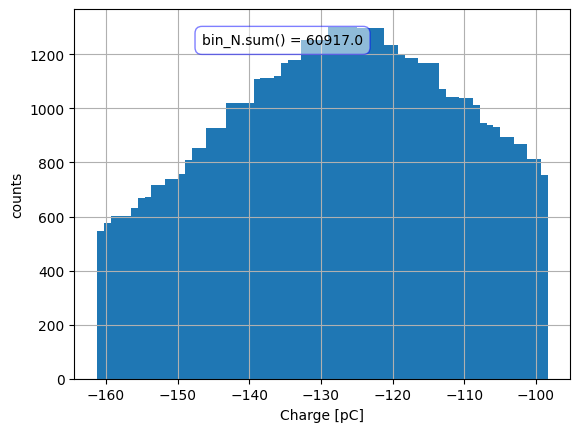

In [118]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

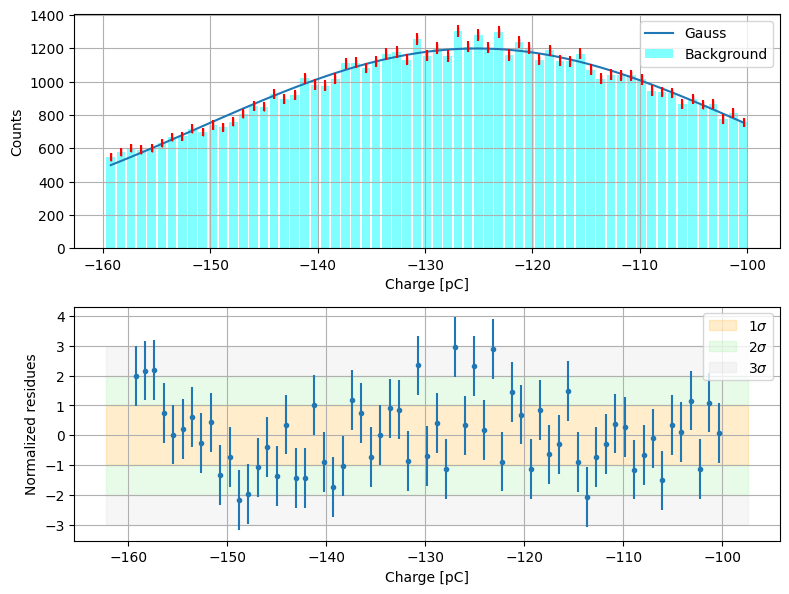

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 63
    # variables        = 3
    chi-square         = 95.9540632
    reduced chi-square = 1.59923439
    Akaike info crit   = 32.5062951
    Bayesian info crit = 38.9356992
    R-squared          = 0.96493074
[[Variables]]
    g3_amplitude:  77313.8290 +/- 805.115998 (1.04%) (init = 42070.28)
    g3_center:    -125.157124 +/- 0.23948139 (0.19%) (init = -124.625)
    g3_sigma:      25.7423948 +/- 0.35859012 (1.39%) (init = 18.525)
    g3_fwhm:       60.6187061 +/- 0.84441519 (1.39%) == '2.3548200*g3_sigma'
    g3_height:     1198.16967 +/- 8.58693511 (0.72%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.8656
    C(g3_amplitude, g3_center) = +0.4541
    C(g3_center, g3_sigma)     = +0.4295


In [119]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## peak 3

In [120]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [81]:
lim_list = [[-575, -460],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1850, -1550],  #ch2
            [-900, -700],  #ch3
            [-400, -200],  #ch4
            [-1400, -1160],  #ch5
            [-920, -775],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

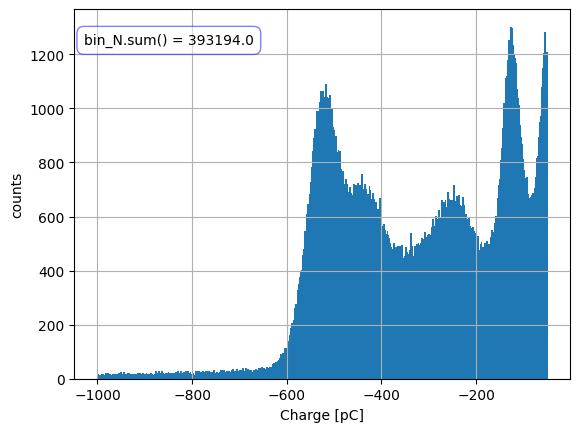

In [121]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

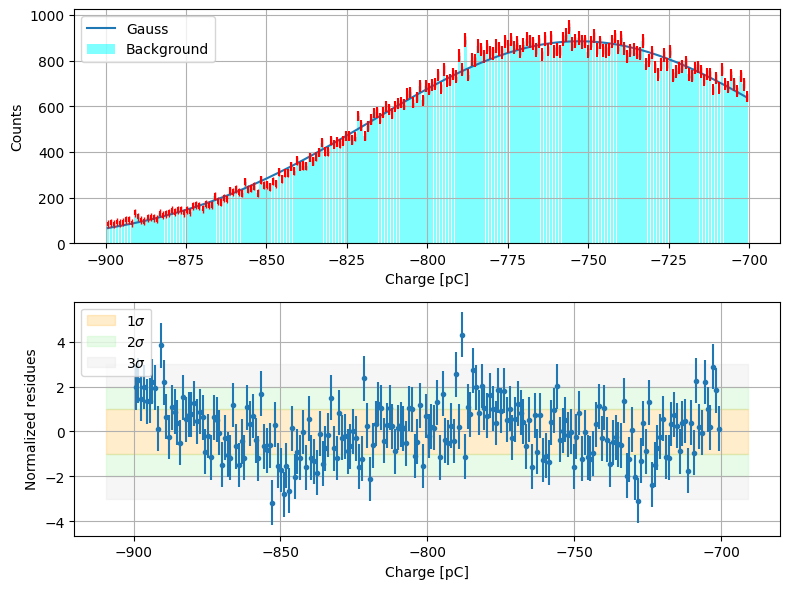

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 210
    # variables        = 3
    chi-square         = 324.792130
    reduced chi-square = 1.56904411
    Akaike info crit   = 97.5763478
    Bayesian info crit = 107.617670
    R-squared          = 0.98966486
[[Variables]]
    g3_amplitude:  143115.887 +/- 879.283955 (0.61%) (init = 155819.5)
    g3_center:    -752.728639 +/- 0.53098456 (0.07%) (init = -760.1552)
    g3_sigma:      64.4865006 +/- 0.42248465 (0.66%) (init = 60.325)
    g3_fwhm:       151.854101 +/- 0.99487530 (0.66%) == '2.3548200*g3_sigma'
    g3_height:     885.378811 +/- 3.94349664 (0.45%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_center, g3_sigma)     = +0.7820
    C(g3_amplitude, g3_center) = +0.7623
    C(g3_amplitude, g3_sigma)  = +0.7556


In [83]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## conclusions

In [ ]:
#      [0,1,2,     3,    4,5,6,7,8,9,10,11,12,13,14,15]
peak_1=[0,0,0,  -74.440, -49.941]
err_1=[0,0,0,  0.680, 2.493]
peak_2=[0,0,0, -178.235, -125.157]
err_2=[0,0,0,  0.340, 0.239]
peak_3=[0,0,0,  -752.729]
err_3=[0, 0, 0,  0.531, ]
#peak_4=[]
#err_4=[]


# Linearity

In [91]:
new_sigma_e= np.sqrt(sigma_e**2 + (0.01*peak_e)**2)
new_sigma_f= np.sqrt(sigma_e**2 + (0.01*peak_e)**2)
energy=np.array((511, 1274))

In [94]:
#faccio intercalibrazione rispetto al canale 2
lista=np.arange(0,16,step=1)
channel_ref=2
coeff_cal=peak_e/peak_e[channel_ref]
err_e=new_sigma_e/coeff_cal

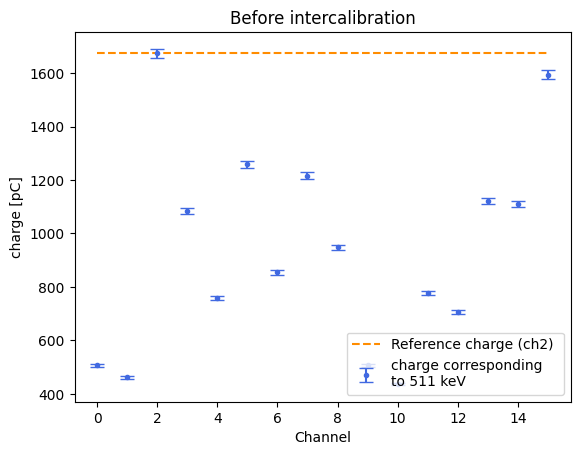

In [95]:
ref=peak_e[channel_ref]

plt.errorbar(lista, peak_e, yerr=new_sigma_e, ls='', capsize=5, marker='.', color='royalblue', label='charge corresponding\nto 511 keV')
plt.title("Before intercalibration")
plt.plot(lista, 0*np.array(lista) + ref, color='darkorange', ls='--', label='Reference charge (ch2) '.format(channel_ref))
plt.xlabel('Channel')
plt.ylabel("charge [pC]")
plt.legend(loc='lower right')

[-1.44051793  5.86447497  0.          5.25250137 -1.02522667  3.03184712
  1.30303538 -0.10390771 -0.37303776 -1.24878598 -0.160084    3.18229741
  3.24594322  1.57358107  1.42851281 -0.80625922]
[0.00420568 0.00409842 0.0041426  0.00406323 0.00417089 0.00411156
 0.00414028 0.00415852 0.00415441 0.00428346 0.00416583 0.00411595
 0.004142   0.00412752 0.004133   0.00417307]


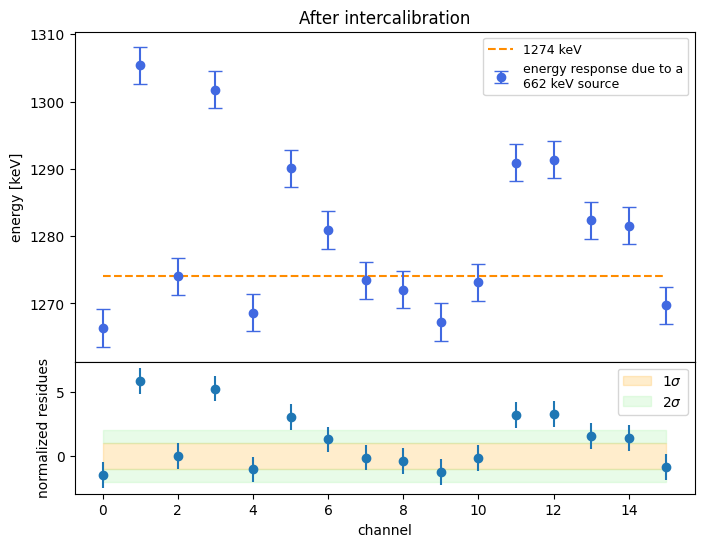

In [96]:
test_peak_centers=peak_f/coeff_cal

test_peak_errors=new_sigma_f/coeff_cal
ref=peak_f[channel_ref]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [5, 2]})

print( (test_peak_centers-ref)/test_peak_errors  )
ax1.plot(lista, 0*np.array(lista) + 1274, color='darkorange', ls='--', label='1274 keV '.format(channel_ref))
ax1.errorbar(lista, test_peak_centers*1274/ref, yerr=test_peak_errors*662/np.abs(ref), ls='', capsize=5, marker='o', color='royalblue', label='energy response due to a\n662 keV source')
ax1.legend(fontsize=9)
ax1.set_title("After intercalibration")
ax1.set_ylabel("energy [keV]")

xlim = ax1.get_xlim()
ax2.errorbar(lista,(np.array(test_peak_centers)-ref)/np.array(test_peak_errors), yerr=1, ls=' ', marker='o')
ax2.fill_between([0,15], [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between([0,15], [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between([0,15], [2, 2], [1, 1], color = "lightgreen", alpha = 0.2)
ax2.set_xlabel("channel")
ax2.set_ylabel("normalized residues")
ax2.legend()
plt.subplots_adjust(hspace=0)

print(test_peak_errors/test_peak_centers)

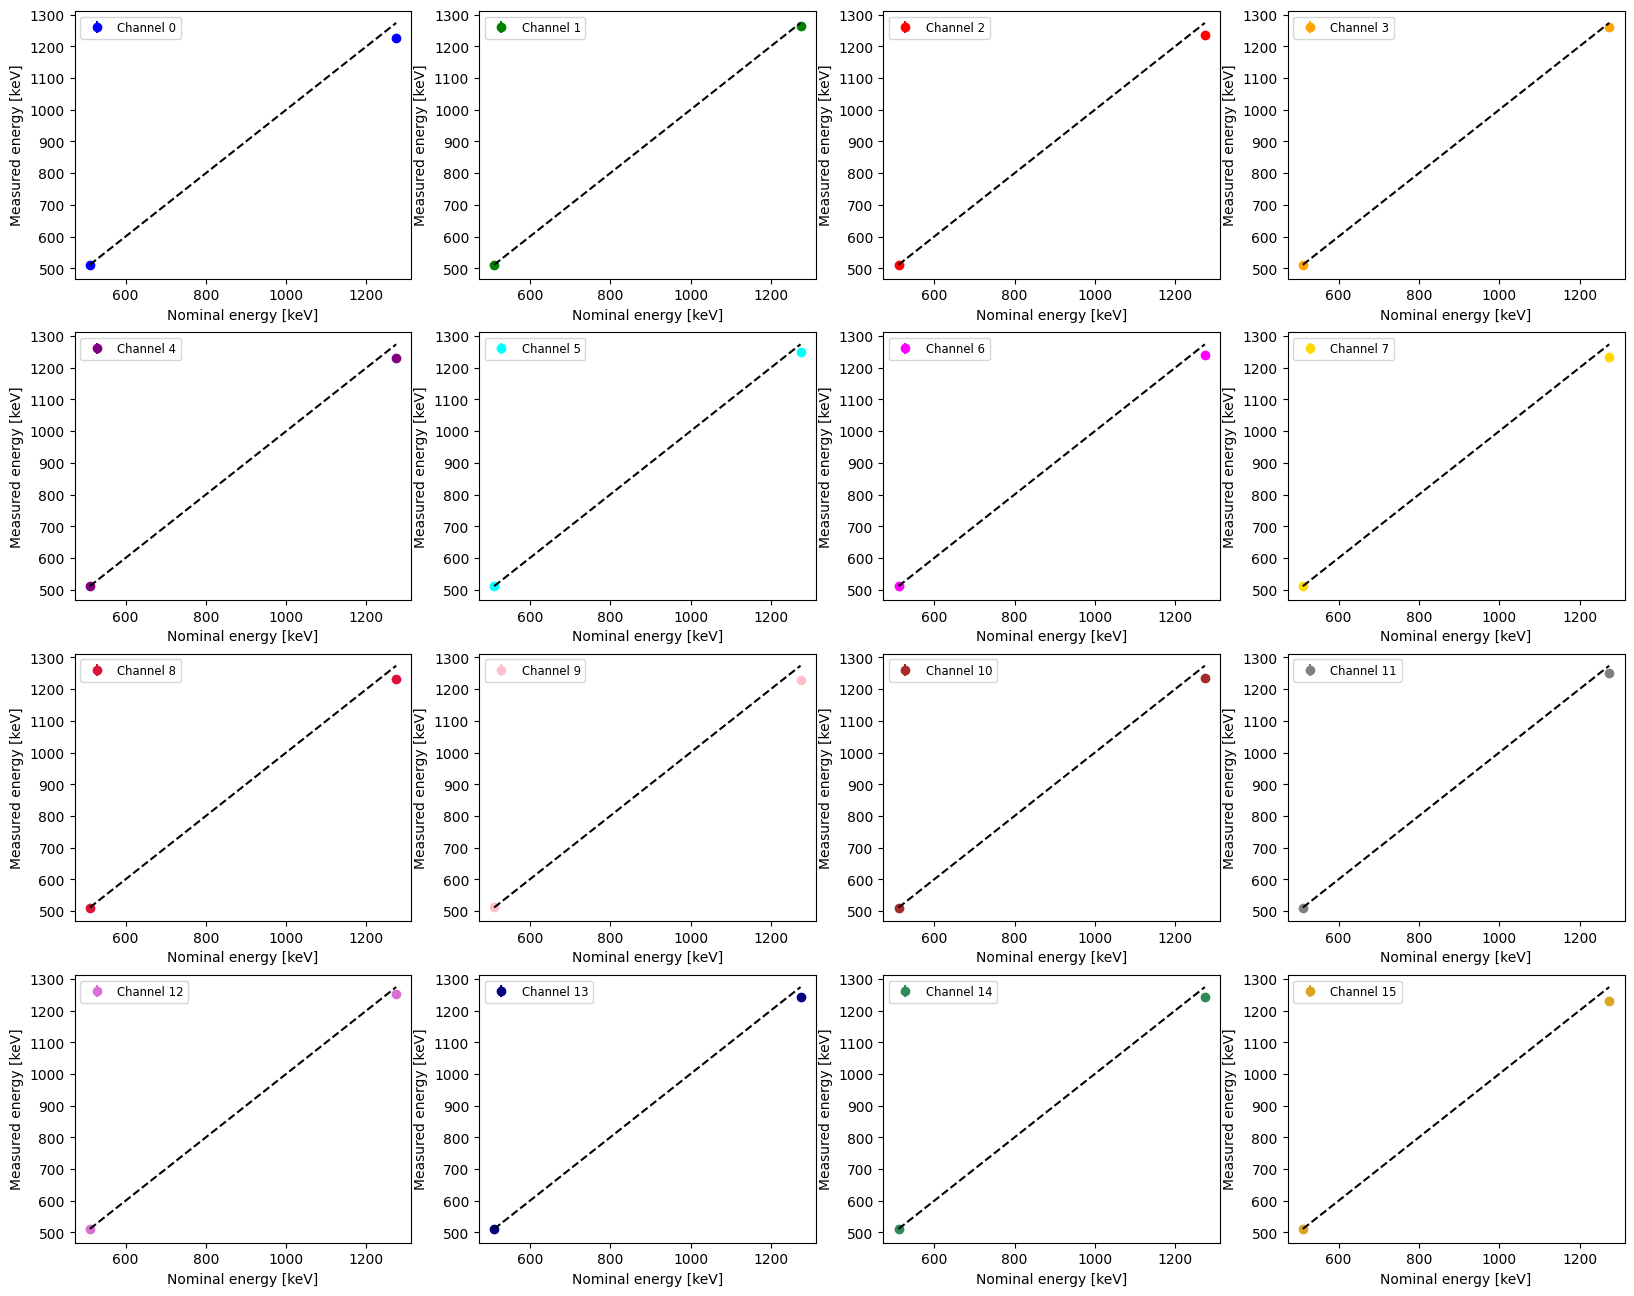

In [98]:

ch=np.arange(0,16,step=1)
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'gold', 'crimson', 'pink', 'brown', 'gray', 'orchid', 'navy', 
          'seagreen', 'goldenrod']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))#, sharex=True)
ref_g=peak_e[channel_ref]
energia=511/ref_g
energy_g=peak_e/coeff_cal*energia
sigma_g=new_sigma_e/coeff_cal*energia
ref_f=peak_f[channel_ref]
energy_f=test_peak_centers*energia
sigma_f=test_peak_errors*energia
# Iterate over each element in channels
for j, color in enumerate(colors):
    # Calculate subplot row and column
    row = j // 4
    col = j % 4
    
    # Plot error bars on the corresponding subplot with different color
    axes[row, col].errorbar(energy, np.array([energy_g[j], energy_f[j]]), yerr=np.array([sigma_g[j], sigma_f[j]]), 
                            ls='', marker='o', color=color, label='Channel {}'.format(j))

   

    axes[row, col].errorbar(energy, energy, ls='--', color='black')
    
    axes[row, col].set_xlabel("Nominal energy [keV]")
    axes[row, col].set_ylabel("Measured energy [keV]")
    axes[row, col].legend(fontsize='small')  # Add legend for each subplot